# Шаг 1. Загрузка данные и подготовка к анализу

In [ ]:
import pandas as pd #импорт библиотек необходимых для работы
import datetime as dt
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
visits = pd.read_csv('/datasets/visits_info_short.csv') #чтение файлов 
orders = pd.read_csv('/datasets/orders_info_short.csv')
costs = pd.read_csv('/datasets/costs_info_short.csv') 
print(visits.info(), orders.info(), costs.info()) #смотрю какого типа столбцы в датафреймах

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
User Id          309901 non-null int64
Region           309901 non-null object
Device           309901 non-null object
Channel          309901 non-null object
Session Start    309901 non-null object
Session End      309901 non-null object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
User Id     40212 non-null int64
Event Dt    40212 non-null object
Revenue     40212 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
dt         1800 non-null object
Channel    1800 non-null object
costs      1800 non-null float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB
None None None


In [ ]:
visits['Session Start'] = pd.to_datetime(visits['Session Start']) #преобразую все стобцы с времене в тип datetime
visits['Session End'] = pd.to_datetime(visits['Session End'])
orders['Event Dt'] = pd.to_datetime(orders['Event Dt'])
costs['dt'] = pd.to_datetime(costs['dt'])
print(visits.info(), orders.info(), costs.info()) #смотрю поменялся ли тип данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
User Id          309901 non-null int64
Region           309901 non-null object
Device           309901 non-null object
Channel          309901 non-null object
Session Start    309901 non-null datetime64[ns]
Session End      309901 non-null datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
User Id     40212 non-null int64
Event Dt    40212 non-null datetime64[ns]
Revenue     40212 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.6 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
dt         1800 non-null datetime64[ns]
Channel    1800 non-null object
costs      1800 non-null float64
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 42

In [ ]:
def change_name(df):
    """Функция для изменения названия столбцов в датафрейме,
    меняет наименования столбцов на нижний регистр и заменяет пробел на нижнее подчеркивание"""
    df.columns = [x.lower().replace(' ', '_') for x in df.columns.values]
    df.info()
    return df

In [ ]:
visits = change_name(visits)
orders = change_name(orders)
costs = change_name(costs)
#переименовываю столбцы в датафреймах

# Шаг 2. Функции для расчета и анализа LTV, ROI, удержания и конверсии

In [ ]:
def get_profiles(sessions, orders, events, ad_costs, event_names=[]):
    """Функция для нахождения профилей"""
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    for event in event_names:
        if event in events['event_name'].unique():
            profiles[event] = profiles['user_id'].isin(
                events.query('event_name == @event')['user_id'].unique()
            )       
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )
    
    
    new_users['dt'] = pd.to_datetime(new_users['dt'])
    ad_costs['dt'] = pd.to_datetime(ad_costs['dt'])
    
    
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']
    profiles['dt'] = pd.to_datetime(profiles['dt'])
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [ ]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):
    """Функция для нахождения удержания пользователей"""

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - dt.timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [ ]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):
    """Функция для нахлждения конверсии"""

    # Шаг 1. Получить пользовательские профили и данные о покупках
    # передаём их в качестве аргументов profiles и purchases

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - dt.timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # Шаг 2. Найти дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )
    
  
    # Шаг 3. Добавить данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )
    
    # Шаг 4. Рассчитать лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis=1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result


    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [ ]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):
    """Функция для нахождения LTV и ROI"""

    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - dt.timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        result = result.fillna(0).cumsum(axis=1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )
        
        roi = result.div(cac['cac'], axis=0)
        roi = roi[~roi['cohort_size'].isin([np.inf])]
        roi['cohort_size'] = cohort_sizes
        roi['cac'] = cac['cac']
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]
        return result, roi

    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )
    if 'cohort' in dimensions:
        dimensions = []
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )


In [ ]:
def filter_data(df, window):
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [ ]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):
    """Функция для отрисовки графиков LTV, ROI, CAC"""

    plt.figure(figsize=(20, 10))

    ltv = ltv.drop(columns=['cohort_size'])
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]
    cac_history = roi_history[['cac']]
    roi = roi.drop(columns=['cohort_size', 'cac'])
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()


In [ ]:
def plot_retention(retention, retention_history, horizon, window=7):
    """Функция для построения графиков удержания"""

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в четвёртой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_conversion(conversion, conversion_history, horizon, window=7):
    """Функция для построения графиков конверсии"""

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [ ]:
events = None
profiles = get_profiles(visits, orders, events, costs)
cr, conversion, conversion_history = get_conversion(profiles, orders, pd.datetime(2019, 11, 1).date(), 14)

# Шаг 3. Маркетинг

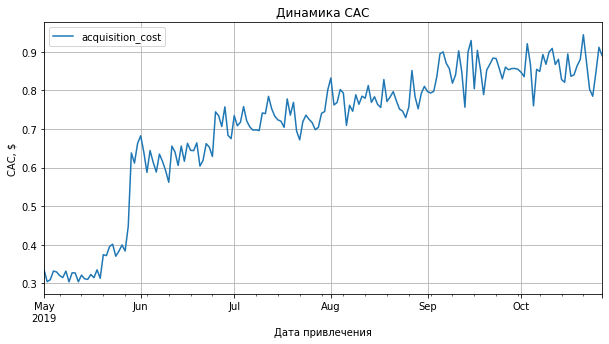

In [ ]:
profiles = get_profiles(visits, orders, events, costs)
profiles.pivot_table(
    index = 'dt', values='acquisition_cost', aggfunc='mean'
).plot(grid = True, figsize=(10, 5))
plt.ylabel('CAC, $')
plt.xlabel('Дата привлечения')
plt.title('Динамика САС')
plt.show()
#строю график обей динамики CAC

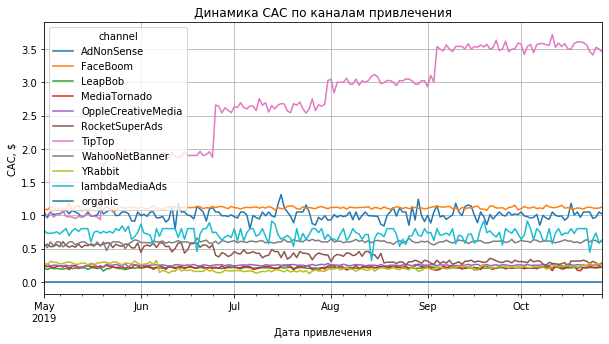

In [ ]:
profiles.pivot_table(
    index='dt', columns='channel', values='acquisition_cost', aggfunc='mean'
).plot(grid=True, figsize=(10, 5))
plt.ylabel('CAC, $')
plt.xlabel('Дата привлечения')
plt.title('Динамика САС по каналам привлечения')
plt.show()
#строю график динамики CAC в разбивке по каналам привлечения

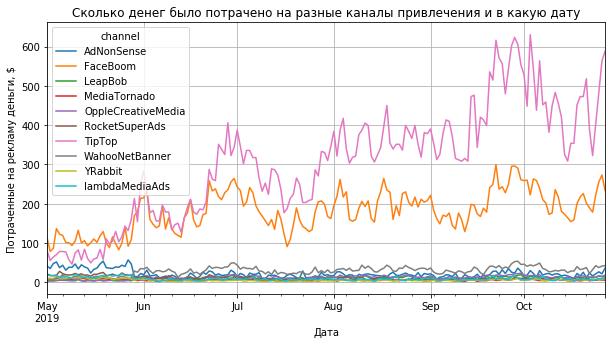

In [ ]:
costs.pivot_table(
    index = 'dt', columns = 'channel',  values = 'costs', aggfunc = 'sum'
).plot(grid = True, figsize=(10, 5))
plt.ylabel('Потраченные на рекламу деньги, $')
plt.xlabel('Дата')
plt.title('Сколько денег было потрачено на разные каналы привлечения и в какую дату')
plt.show()
#строю график по количеству затраченных денег на разные каналы привлечения в разбивке по дате

In [ ]:
profiles['acquisition_cost'].mean() #средняя стоимость привлечения пользователя 

0.7032778251826568

**Вывод:** 
- Стоимость привлечения клиента растет постоянно растет, в конце мая 2019 года, был большой скачек CAC.
- Общая стоимость привлечения клиента растет за счет того, что сильно растет стоимоть привлечения клиентов на ресурсе TipTop. Стоимость привлечения клиентов на остальных ресурсах не сильно растет.
- Количество затраченных на рекламу денег на ресурсе FaceBoom растет, но стоимость привлечения пользователя на этом ресурсе не растет, возмоно это связано с тем, что с этого ресурса стало приходить больше пользователей.

# Шаг 4. Проведите исследовательский анализ данных

In [ ]:
profiles = profiles.query('channel != "organic"').reset_index() #исключаю полдьзователей с каналом привлечения organic

,index,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
3,4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769
4,7,46006712,2019-06-30 03:46:29,AdNonSense,Android,France,2019-06-30,2019-06-01,True,1.008000
...,...,...,...,...,...,...,...,...,...,...
93564,149999,999942424543,2019-05-24 21:03:26,TipTop,iPhone,United States,2019-05-24,2019-05-01,False,1.900000
93565,150001,999949280903,2019-08-12 06:47:27,FaceBoom,Mac,United States,2019-08-12,2019-08-01,False,1.117838
93566,150003,999956196527,2019-09-28 08:33:02,TipTop,iPhone,United States,2019-09-28,2019-09-01,False,3.500000
93567,150005,999976332130,2019-07-23 02:57:06,TipTop,iPhone,United States,2019-07-23,2019-07-01,False,2.600000


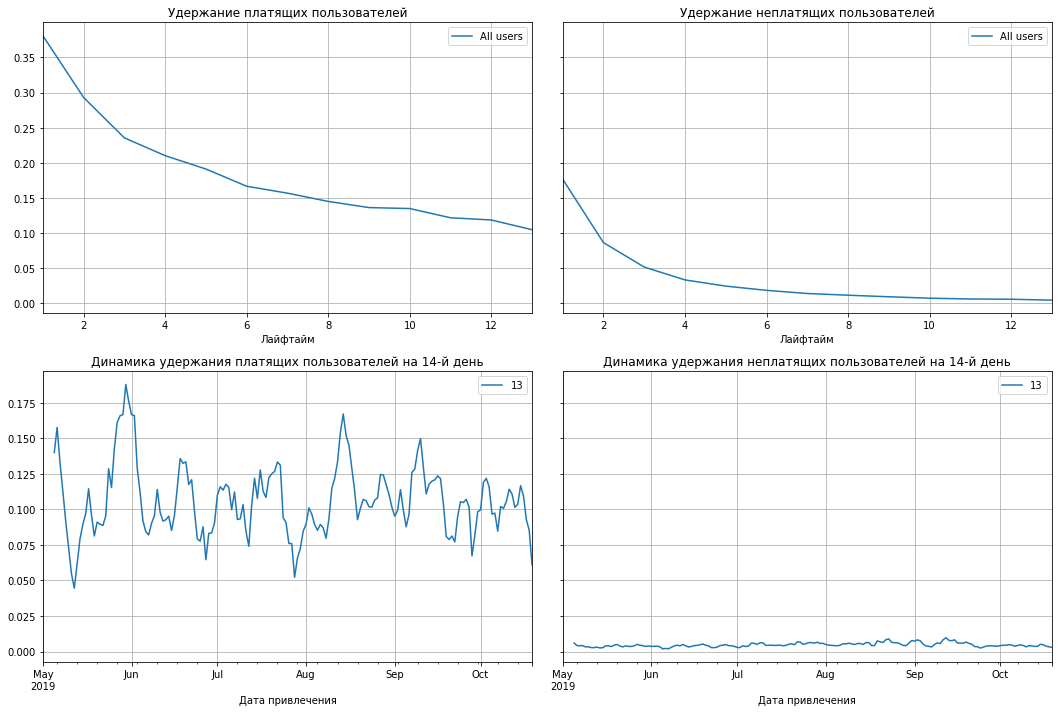

In [ ]:
result_raw, retention, retention_history = get_retention(profiles,
                                                         visits,
                                                         pd.datetime(2019, 11, 1).date(),
                                                         14)
plot_retention(retention, retention_history, 14, 5) 

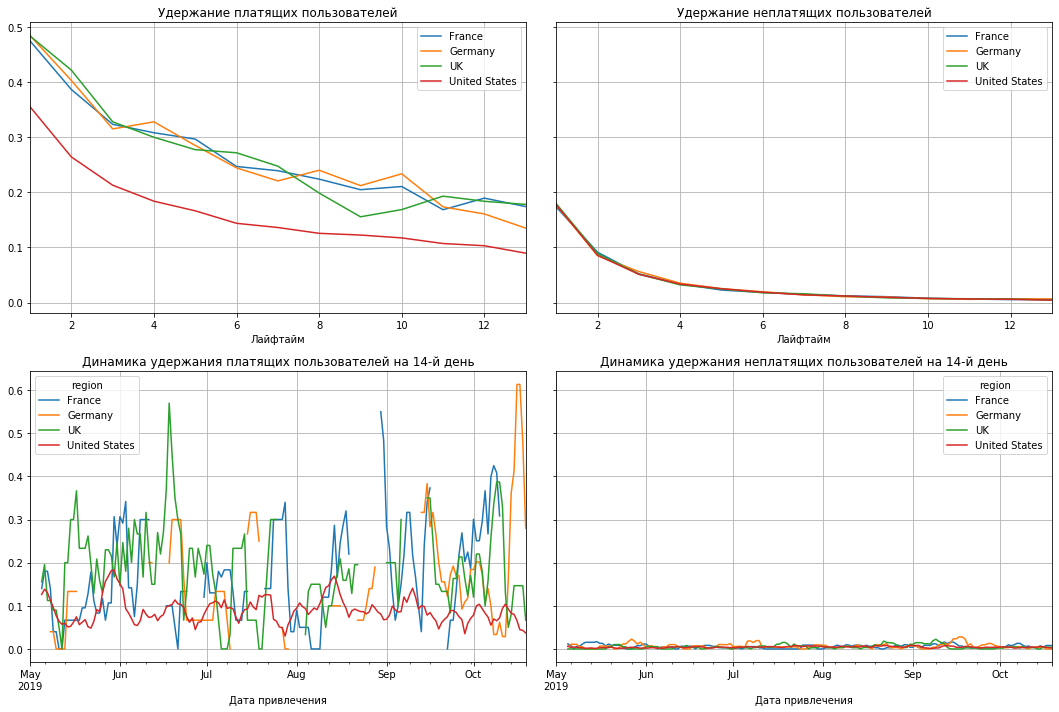

In [ ]:
result_raw, retention, retention_history = get_retention(profiles,
                                                         visits,
                                                         pd.datetime(2019, 11, 1).date(),
                                                         14,
                                                         dimensions = ['region'])
plot_retention(retention, retention_history, 14, 5) 

In [ ]:
retention[['cohort_size']].query('payer == True').sort_values(by = 'cohort_size', ascending = False)
#проверяю сколько платящих пользователей в каждой стране

cohort_size
payer region                    
True  United States         5786
      UK                     534
      France                 523
      Germany                467

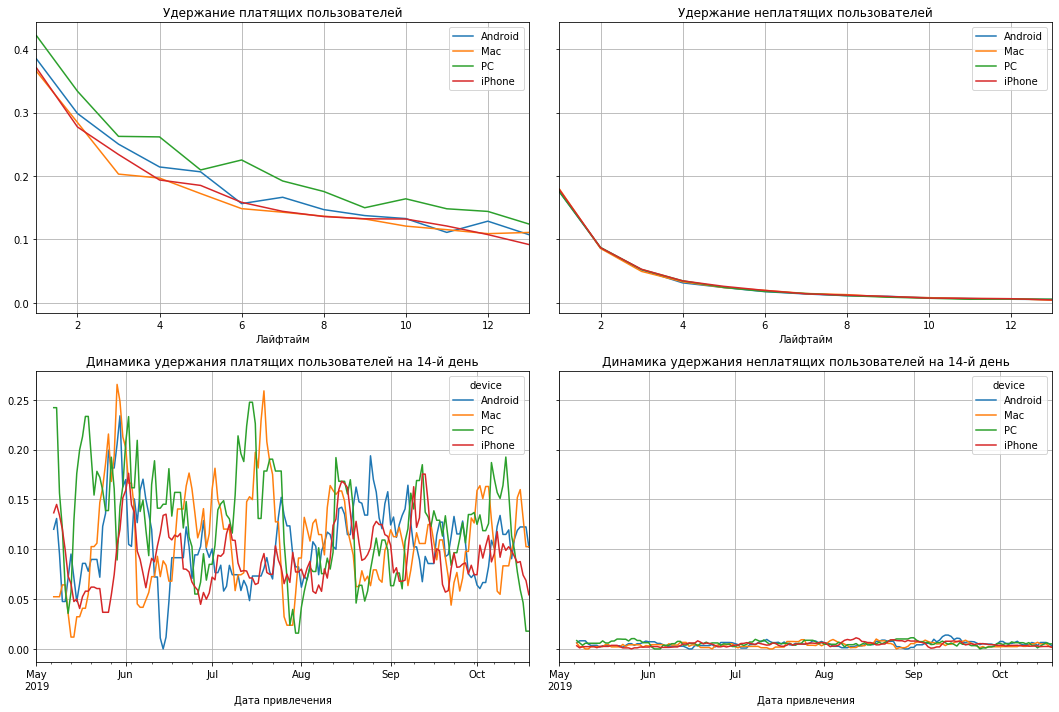

In [ ]:
result_raw, retention, retention_history = get_retention(profiles,
                                                         visits,
                                                         pd.datetime(2019, 11, 1).date(),
                                                         14,
                                                         dimensions = ['device'])
plot_retention(retention, retention_history, 14) 

In [ ]:
retention[['cohort_size']].query('payer == True').sort_values(by = 'cohort_size', ascending = False)
#проверяю какими устройствами пользуются преимущественно платяие пользователи

cohort_size
payer device              
True  iPhone          2810
      Android         1695
      Mac             1597
      PC              1208

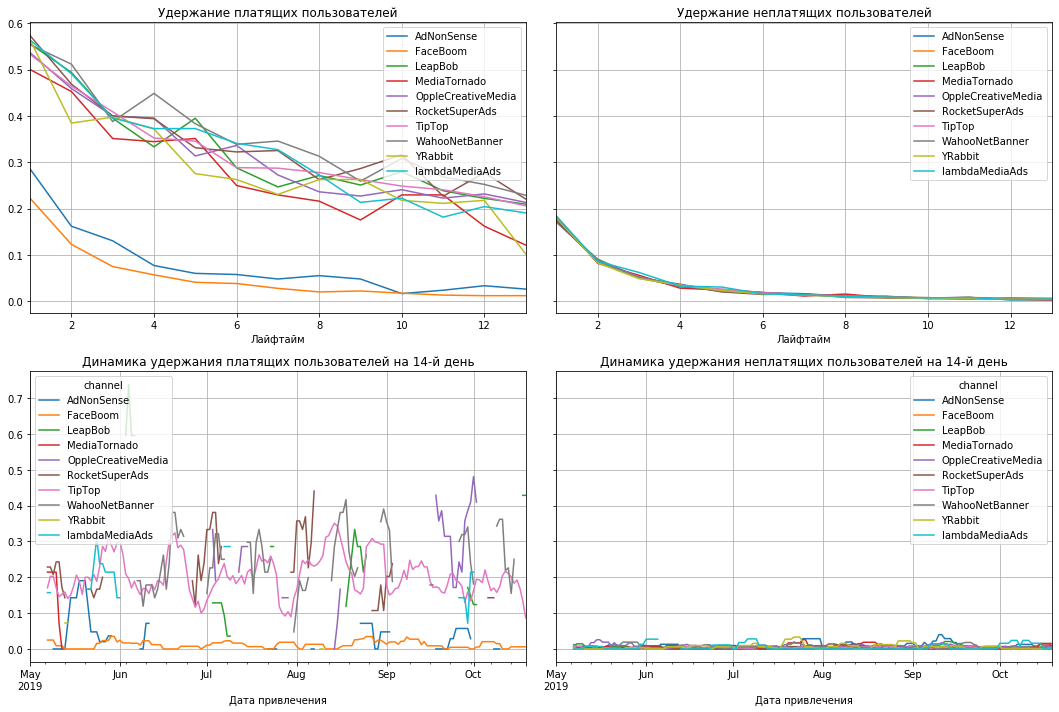

In [ ]:
result_raw, retention, retention_history = get_retention(profiles,
                                                         visits,
                                                         pd.datetime(2019, 11, 1).date(),
                                                         14,
                                                         dimensions = ['channel'])
plot_retention(retention, retention_history, 14) 

In [ ]:
retention[['cohort_size']].query('payer == True').sort_values(by = 'cohort_size', ascending = False)
#проверяю сколько платяих пользователей приходит из каждого источника

cohort_size
payer channel                        
True  FaceBoom                   3362
      TipTop                     1785
      WahooNetBanner              428
      AdNonSense                  413
      RocketSuperAds              335
      LeapBob                     243
      OppleCreativeMedia          220
      lambdaMediaAds              220
      YRabbit                     156
      MediaTornado                148

**Вывод:** 
- Больше всего платящих пользователей приходит из США, но они и меньше всего удерживаются. Пользователи из остальных стран удерживаются примерно одинаково.
- Лучше всего удерживаются плтящие пользователи, которые заходят с PC, хоть в целом приход таких пользователей и меньше.Больше всего пользователей заходят с Iphone, но удерживаются такие пользователи также как и остальные.
- Больше всего платящих пользователей приходит из источника FaceBoom, но удерживаются такие пользователи хуже всего. Лидер по удерживающимся пользователям WahooNetBanner, пользователи из остальных источников удерживаются примерно одинаково.

# Шаг 5. Окупаемость рекламы для привлечения пользователей

## Общую окупаемость рекламы

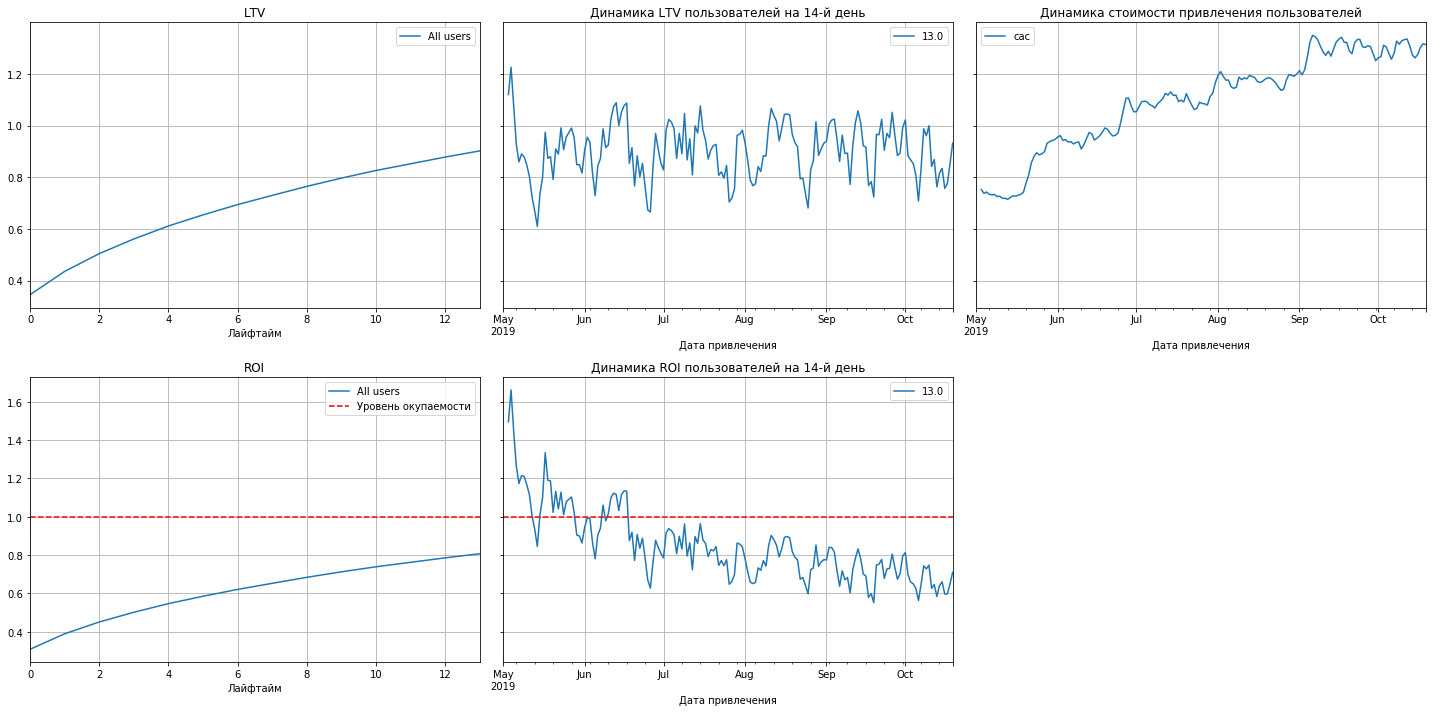

In [ ]:
raw, ltv, ltv_history, roi, roi_history = get_ltv(profiles, orders, pd.datetime(2019, 11, 1).date(), 14)
plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14, window = 3)

## Окупаемость рекламы с разбивкой по устройствам

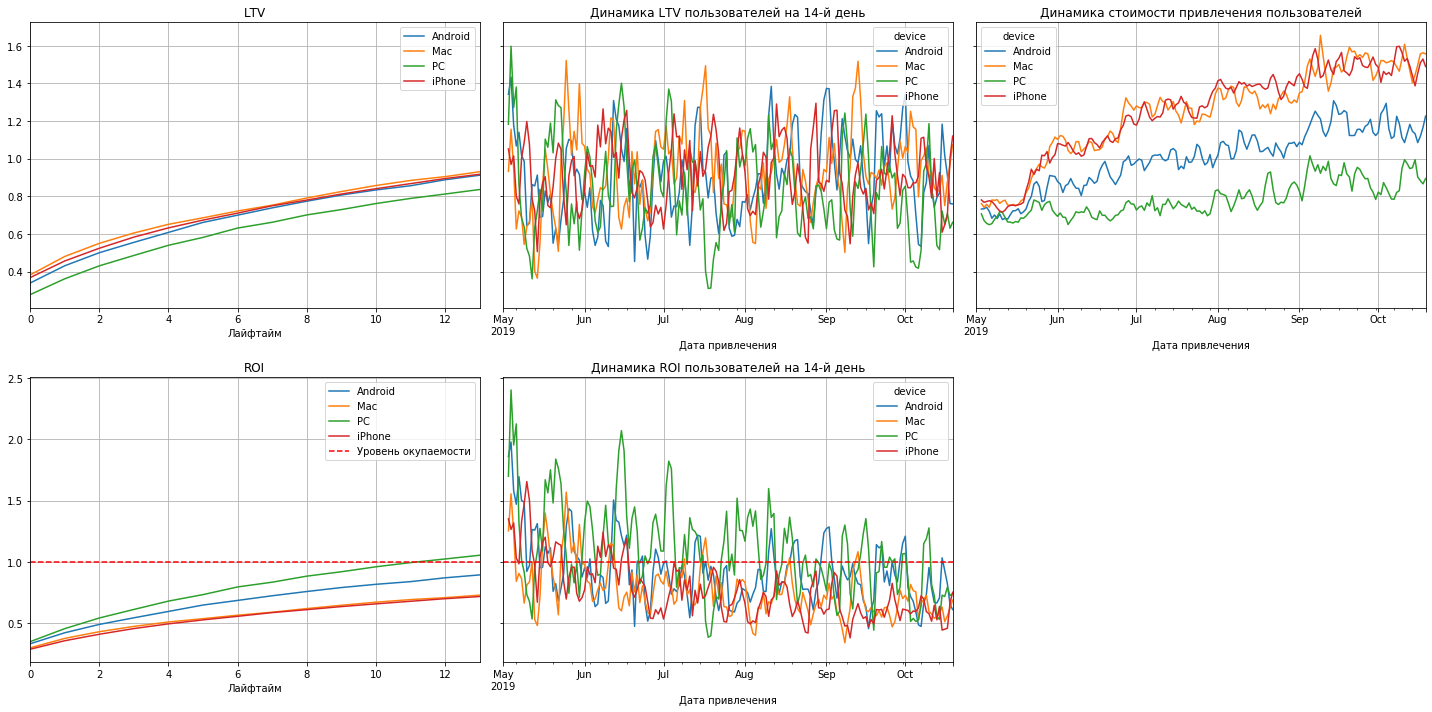

In [ ]:
raw, ltv, ltv_history,roi, roi_history = get_ltv(profiles,
                                                 orders,
                                                 pd.datetime(2019, 11, 1).date(),
                                                 14,
                                                 dimensions = ['device'])
plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14, window = 3)

In [ ]:
raw, ltv, ltv_history,roi, roi_history = get_ltv(profiles,
                                                 orders,
                                                 pd.datetime(2019, 11, 1).date(),
                                                 14,
                                                 dimensions = ['region', 'device'])

roi['share'] = roi['cohort_size'] / roi['cohort_size'].sum() *100
roi[['cohort_size', 'share']].sort_values(by = 'share', ascending = False)#доля пользователей в разрбивке по стране и устройству

cohort_size      share
region        device                         
United States iPhone         26092  29.434592
              Mac            14635  16.509860
              Android        11769  13.276702
              PC              6066   6.843103
UK            PC              4292   4.841839
France        PC              4168   4.701954
Germany       PC              3602   4.063445
France        Android         3151   3.554668
UK            Android         3070   3.463291
Germany       Android         2693   3.037995
UK            iPhone          2136   2.409639
France        iPhone          2091   2.358874
Germany       iPhone          1767   1.993367
France        Mac             1106   1.247687
UK            Mac             1038   1.170976
Germany       Mac              968   1.092008

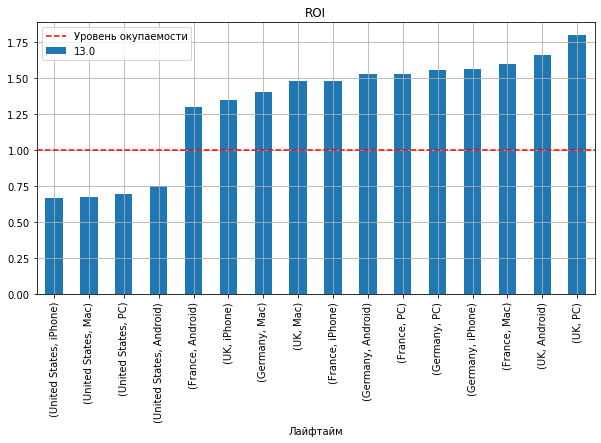

In [ ]:
roi = roi.sort_values(by = 13.0)
roi = roi.drop(columns=['cohort_size', 'cac', 'share'])
roi[13.0].T.plot(kind = 'bar', grid=True, figsize = (10, 5))
plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
plt.legend()
plt.xlabel('Лайфтайм')
plt.title('ROI')
plt.show()
#строю график окупаемости по стране и устройству

## Окупаемость рекламы с разбивкой по странам

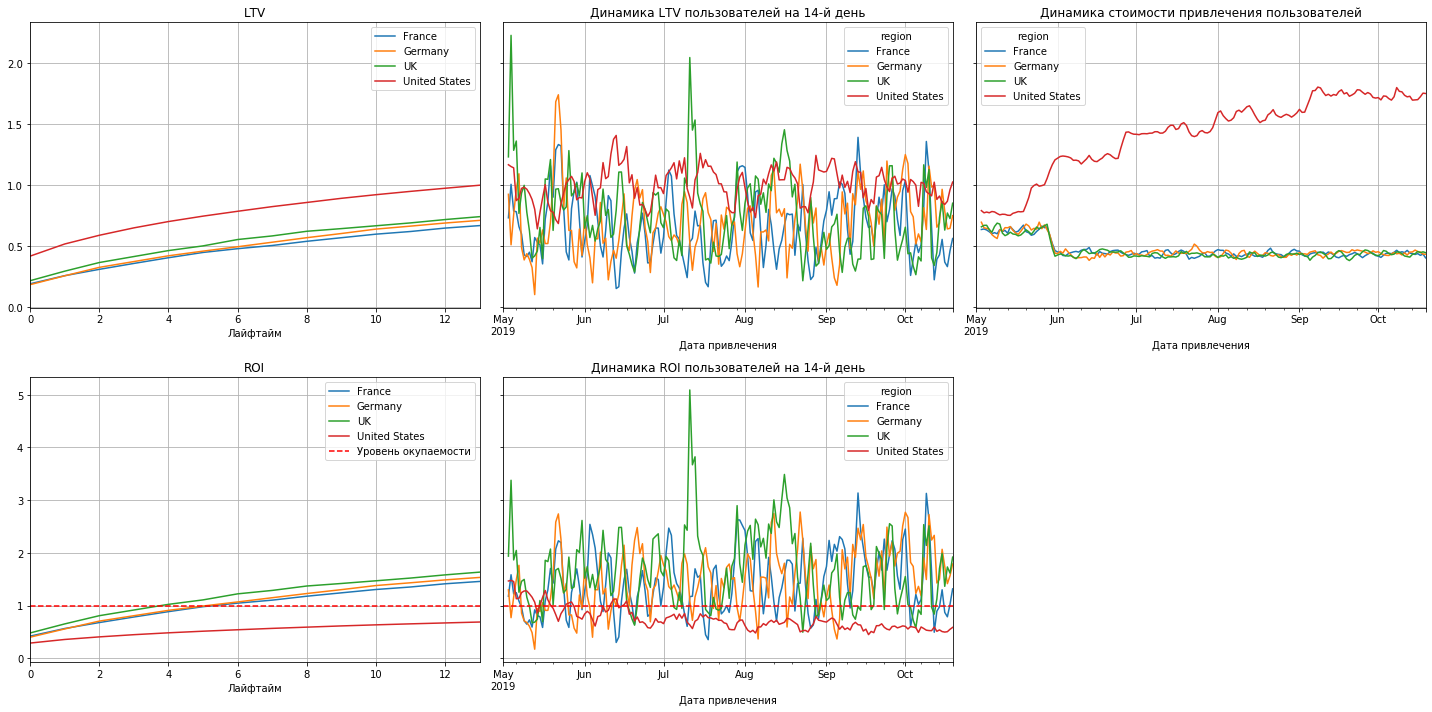

In [ ]:
raw, ltv, ltv_history,roi, roi_history = get_ltv(profiles,
                                                 orders,
                                                 pd.datetime(2019, 11, 1).date(),
                                                 14,
                                                 dimensions = ['region'])
plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14, window = 3)

In [ ]:
raw, ltv, ltv_history,roi, roi_history = get_ltv(profiles,
                                                 orders,
                                                 pd.datetime(2019, 11, 1).date(),
                                                 14,
                                                 dimensions = ['region', 'channel'])

roi['share'] = roi['cohort_size'] / roi['cohort_size'].sum() *100
roi[['cohort_size', 'share']].sort_values(by = 'share', ascending = False)
#доля пользователей в разбивке по стране и источнику привлечения

cohort_size      share
region        channel                                   
United States FaceBoom                  27544  31.072605
              TipTop                    18498  20.867741
              RocketSuperAds             4251   4.795587
              MediaTornado               4167   4.700826
              YRabbit                    4102   4.627499
UK            LeapBob                    2886   3.255720
              OppleCreativeMedia         2878   3.246695
France        LeapBob                    2839   3.202698
              WahooNetBanner             2834   3.197058
              OppleCreativeMedia         2830   3.192545
UK            WahooNetBanner             2809   3.168855
Germany       WahooNetBanner             2439   2.751455
              OppleCreativeMedia         2431   2.742430
              LeapBob                    2378   2.682641
France        AdNonSense                 1305   1.472181
UK            AdNonSense                 1237   1.395470
Germany       AdNonSense                 1160   1.308605
UK            lambdaMediaAds              726   0.819006
France        lambdaMediaAds              708   0.798700
Germany       lambdaMediaAds              622   0.701683

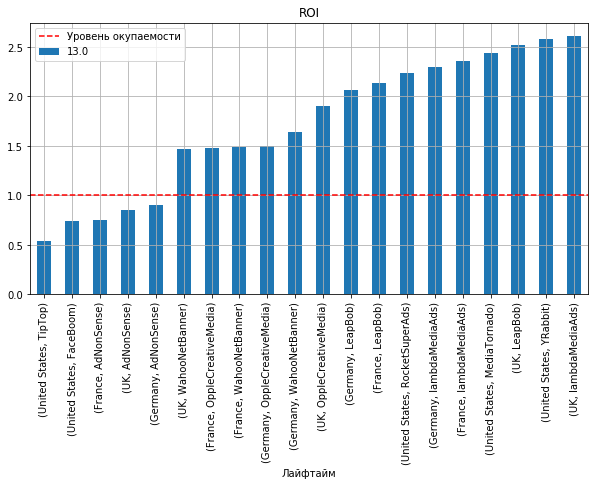

In [ ]:
roi = roi.sort_values(by = 13.0)
roi = roi.drop(columns=['cohort_size', 'cac', 'share'])
roi[13.0].T.plot(kind = 'bar', grid=True, figsize = (10, 5))
plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
plt.legend()
plt.xlabel('Лайфтайм')
plt.title('ROI')
plt.show()
#график окупаемости по стране и источнику привлечения

## Окупаемость рекламы с разбивкой по рекламным каналам

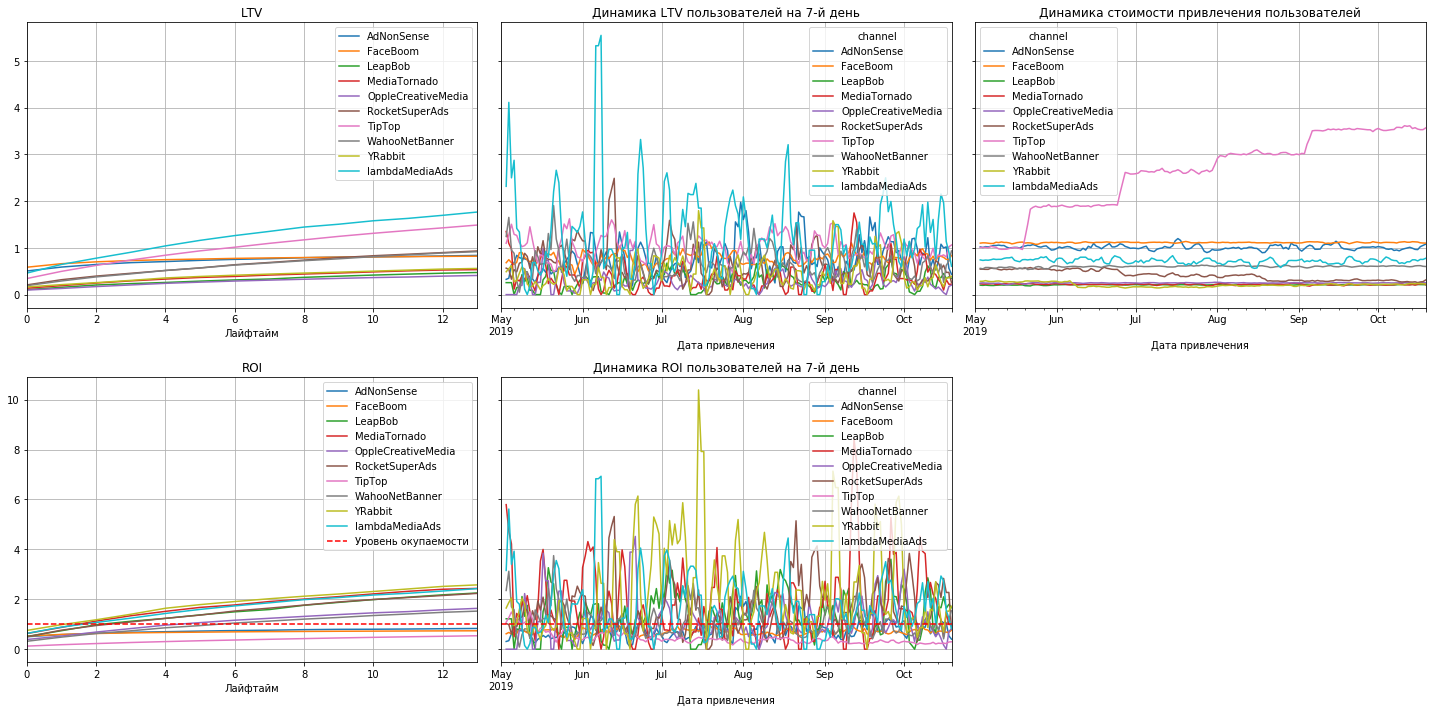

In [ ]:
raw, ltv, ltv_history,roi, roi_history = get_ltv(profiles,
                                                 orders,
                                                 pd.datetime(2019, 11, 1).date(),
                                                 14,
                                                 dimensions = ['channel'])
plot_ltv_roi(ltv, ltv_history, roi, roi_history, 7, window = 3)

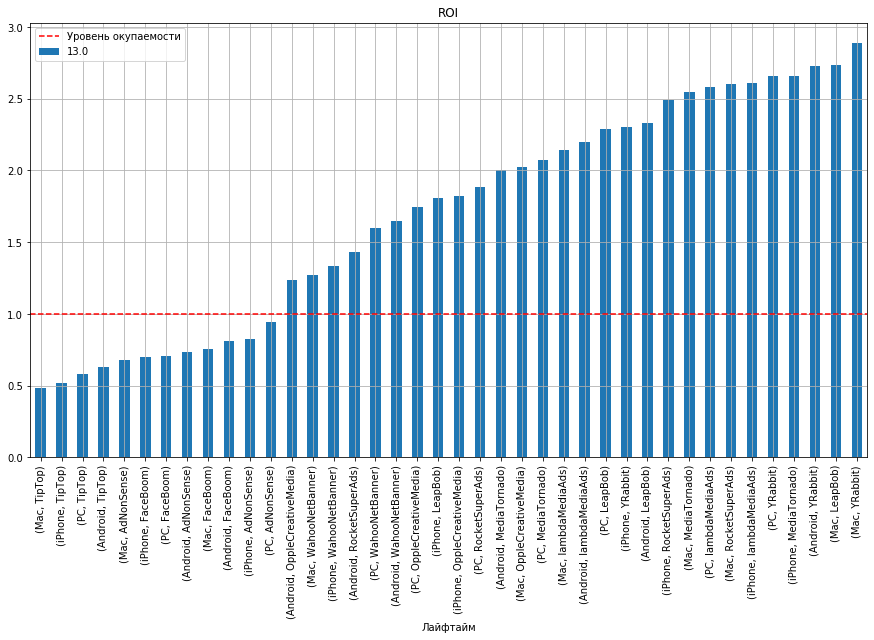

In [ ]:
raw, ltv, ltv_history,roi, roi_history = get_ltv(profiles,
                                                 orders,
                                                 pd.datetime(2019, 11, 1).date(),
                                                 14,
                                                 dimensions = ['device', 'channel'])

roi = roi.sort_values(by = 13.0)
roi = roi.drop(columns=['cohort_size', 'cac'])
roi[13.0].T.plot(kind = 'bar', grid=True, figsize = (15, 8))
plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
plt.legend()
plt.xlabel('Лайфтайм')
plt.title('ROI')
plt.show()
#график окупаемости по устройству и источнику привлечения

**Вывод:**
- Несмотря на то, что окупаемость постоянно растет, на протяжнии 14 лайфтаймов реклама не окупается.
- По динамике ROI можно понять, что до середины июня на 14 лайфтайм реклама окупалась, хоть и окупаемость рекламы шла вниз. Но начиная с середины июня реклама на 14 лайфтайм перестает окупаться.
- По графику ROI с разбивкой по устройствам можно понять, что пользователь Iphone и Mac не окупаются на протяжении всех лайфтаймов. Пользователи PC начинают окупаться быстрее остальных, начиная с 7 лайфтайма. Пользователи Android начинают окупаться с 11 лайфтайма.
- Пользователи из Франции, Герании и Англии одинаково быстро. А пользователи из США совсем не окупаются.
- Если посмотреть на график динамики ROI с разбивкой по странам, то видно, что пользователи Франции, Герании и Англии почти всегда окупаются на 14 лайфтайм, а пользователи из США окупались до середины июня, а потом перестали окупаться.
- Пользователи из источников TipTop, FaceBoom и AdNonSense -  не окупаются, в то время как пользователи из остальных источников окупаются.

# Шаг 6. Общий вывод

**Вывод:**

- График ROI с разбивкой по источникам показал, что пользователи из источников TipTop, FaceBoom и AdNonSense не окупаются. Так как из источников TipTop и FaceBoom приходили только пользователи из США, то график ROI с разбивкой по странам показывает, что пользователи из США не окупаются. Хотя пользователи из США, которые пришли из других источников - окупаются. Также график ROI с разбивкой по устройства показывает, что пользователи Iphone и Mac не окупаются, это связано с тем, что больший процент пользователей этих устройств приходят из США.

- Прична того, что пользователи из источника TipTop не окупаются, может быть в том, что стоимость привлечения пользователей из этого источника сильно растет.

- Все пользователи из источника AdNonSense, независимо от страны или устройства, которым они пользуются - не окупаются. Причина может быть в том, что удержание пользователей из этого источника очень низкое.

- Хоть количество денег затраченных на привлечение пользователей из источника FaceBoom растет но цена привлечения пользователя остается прежней, дело в том, что количество пользователей пришедших из данного источника растет. Но удержание этих пользователей очень низкое, поэтому данный источник не окупается.

- Отделу макетинга возможно стоит отказаться от источников привлечения FaceBoom и AdNonSense эти источники не окупаются и у них низкое удержание пользователей. Стоит поикать причину почему у этих источников низкое удержание.

- Стоимости привлечения пользователей из источника TipTop дорожает из-за этого пользователи перестают окупаться. Возможно стоит рассмотреть источники с более низкой стоимостью привлечения пользователя.